In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the data
print("Loading data...")
df = pd.read_csv(r"C:\Users\sk282\Downloads\archive\UCI_Credit_Card.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Loading data...
Dataset shape: (30000, 25)

Columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']


In [12]:
# STEP 1: DATA PREPROCESSING
print("\n" + "="*50)
print("STEP 1: DATA PREPROCESSING")
print("="*50)

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Separate features and target
X = df.drop('default.payment.next.month', axis=1)
y = df['default.payment.next.month']

# Remove ID column if exists
if 'ID' in X.columns:
    X = X.drop('ID', axis=1)

print(f"\nTarget distribution:\n{y.value_counts()}")
print(f"\nClass imbalance ratio: {y.value_counts()[0]/y.value_counts()[1]:.2f}:1")

# Handle any outliers using IQR method (optional but recommended)
def remove_outliers_iqr(df, columns, multiplier=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - multiplier * IQR
        upper = Q3 + multiplier * IQR
        df_clean[col] = df_clean[col].clip(lower, upper)
    return df_clean

# Apply outlier treatment to numerical columns
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = remove_outliers_iqr(X, numerical_cols)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# HANDLE CLASS IMBALANCE using SMOTE
print("\n" + "="*50)
print("HANDLING CLASS IMBALANCE")
print("="*50)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

print(f"\nBefore SMOTE - Class distribution:")
print(f"Class 0: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.2f}%)")
print(f"Class 1: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.2f}%)")

# Apply SMOTE with RandomUnderSampler for balanced approach
smote = SMOTE(sampling_strategy=0.8, random_state=42)  # Oversample minority to 80% of majority
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # Then balance

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)

print(f"\nAfter SMOTE + Undersampling - Class distribution:")
print(f"Class 0: {sum(y_train_resampled == 0)} ({sum(y_train_resampled == 0)/len(y_train_resampled)*100:.2f}%)")
print(f"Class 1: {sum(y_train_resampled == 1)} ({sum(y_train_resampled == 1)/len(y_train_resampled)*100:.2f}%)")

# Standardize features AFTER resampling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Update y_train to use resampled version
y_train = y_train_resampled

print(f"\nTraining set size: {X_train_scaled.shape}")
print(f"Test set size: {X_test_scaled.shape}")


STEP 1: DATA PREPROCESSING

Missing values:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

Target distribution:
default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64

Class imbalance ratio: 3.52:1

HANDLING CLAS

In [13]:
# STEP 2: FILTER METHOD - Feature Selection
print("\n" + "="*50)
print("STEP 2: FILTER METHOD - FEATURE SELECTION")
print("="*50)

# Method 1: ANOVA F-test
selector_anova = SelectKBest(score_func=f_classif, k=15)
selector_anova.fit(X_train_scaled, y_train)
anova_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'ANOVA_Score': selector_anova.scores_
}).sort_values('ANOVA_Score', ascending=False)

print("\nTop 15 features by ANOVA F-test:")
print(anova_scores.head(15))

# Method 2: Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=15)
selector_mi.fit(X_train_scaled, y_train)
mi_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'MI_Score': selector_mi.scores_
}).sort_values('MI_Score', ascending=False)

print("\nTop 15 features by Mutual Information:")
print(mi_scores.head(15))

# Combine both methods - select features that appear in top 15 of either
top_features_anova = set(anova_scores.head(15)['Feature'].tolist())
top_features_mi = set(mi_scores.head(15)['Feature'].tolist())
selected_features_filter = list(top_features_anova.union(top_features_mi))

print(f"\nTotal features selected by filter methods: {len(selected_features_filter)}")
print(f"Features: {selected_features_filter}")

X_train_filtered = X_train_scaled[selected_features_filter]
X_test_filtered = X_test_scaled[selected_features_filter]


STEP 2: FILTER METHOD - FEATURE SELECTION

Top 15 features by ANOVA F-test:
      Feature  ANOVA_Score
5       PAY_0  4272.302990
6       PAY_2  2517.461435
7       PAY_3  2022.993682
8       PAY_4  1656.075216
9       PAY_5  1333.453175
0   LIMIT_BAL  1267.221367
1         SEX  1255.356951
17   PAY_AMT1  1153.264974
10      PAY_6  1094.933942
18   PAY_AMT2  1020.927547
3    MARRIAGE   976.379112
19   PAY_AMT3   924.052652
22   PAY_AMT6   803.149200
21   PAY_AMT5   712.698916
20   PAY_AMT4   678.587741

Top 15 features by Mutual Information:
      Feature  MI_Score
4         AGE  0.283595
5       PAY_0  0.240019
6       PAY_2  0.167255
2   EDUCATION  0.160354
7       PAY_3  0.144006
8       PAY_4  0.132421
9       PAY_5  0.122911
10      PAY_6  0.121596
0   LIMIT_BAL  0.074068
22   PAY_AMT6  0.070731
17   PAY_AMT1  0.067767
19   PAY_AMT3  0.066199
18   PAY_AMT2  0.065158
21   PAY_AMT5  0.062226
20   PAY_AMT4  0.061603

Total features selected by filter methods: 17
Features: ['PAY_AMT1

In [14]:
# STEP 3: PARTICLE SWARM OPTIMIZATION for LightGBM
print("\n" + "="*50)
print("STEP 3: PARTICLE SWARM OPTIMIZATION")
print("="*50)

class Particle:
    def __init__(self, bounds):
        self.position = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
        self.velocity = np.random.uniform(-1, 1, len(bounds))
        self.best_position = self.position.copy()
        self.best_score = -np.inf
        
class PSO:
    def __init__(self, n_particles, bounds, n_iterations, w=0.7, c1=1.5, c2=1.5):
        self.n_particles = n_particles
        self.bounds = bounds
        self.n_iterations = n_iterations
        self.w = w  # inertia weight
        self.c1 = c1  # cognitive parameter
        self.c2 = c2  # social parameter
        self.particles = [Particle(bounds) for _ in range(n_particles)]
        self.global_best_position = None
        self.global_best_score = -np.inf
        self.history = []
        
    def optimize(self, objective_function):
        for iteration in range(self.n_iterations):
            for particle in self.particles:
                # Evaluate fitness
                score = objective_function(particle.position)
                
                # Update personal best
                if score > particle.best_score:
                    particle.best_score = score
                    particle.best_position = particle.position.copy()
                
                # Update global best
                if score > self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = particle.position.copy()
            
            # Update velocities and positions
            for particle in self.particles:
                r1, r2 = np.random.random(len(self.bounds)), np.random.random(len(self.bounds))
                cognitive = self.c1 * r1 * (particle.best_position - particle.position)
                social = self.c2 * r2 * (self.global_best_position - particle.position)
                particle.velocity = self.w * particle.velocity + cognitive + social
                particle.position = particle.position + particle.velocity
                
                # Apply bounds
                for i, (low, high) in enumerate(self.bounds):
                    particle.position[i] = np.clip(particle.position[i], low, high)
            
            self.history.append(self.global_best_score)
            print(f"Iteration {iteration+1}/{self.n_iterations}, Best Score: {self.global_best_score:.6f}")
        
        return self.global_best_position, self.global_best_score

# Define objective function for LightGBM
def objective_lgbm(params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    learning_rate = params[2]
    num_leaves = int(params[3])
    min_child_samples = int(params[4])
    subsample = params[5]
    colsample_bytree = params[6]
    
    model = lgb.LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        class_weight='balanced',  # Handle any remaining imbalance
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    # Use cross-validation for robust evaluation
    scores = cross_val_score(model, X_train_filtered, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    return scores.mean()

# Define parameter bounds for PSO
bounds = [
    (50, 300),      # n_estimators
    (3, 15),        # max_depth
    (0.01, 0.3),    # learning_rate
    (20, 100),      # num_leaves
    (10, 100),      # min_child_samples
    (0.6, 1.0),     # subsample
    (0.6, 1.0)      # colsample_bytree
]


STEP 3: PARTICLE SWARM OPTIMIZATION


In [15]:
print("\nRunning PSO optimization...")
pso = PSO(n_particles=10, bounds=bounds, n_iterations=15)
best_params, best_score = pso.optimize(objective_lgbm)


Running PSO optimization...
Iteration 1/15, Best Score: 0.803137
Iteration 2/15, Best Score: 0.803137
Iteration 3/15, Best Score: 0.807317
Iteration 4/15, Best Score: 0.807317
Iteration 5/15, Best Score: 0.807317
Iteration 6/15, Best Score: 0.807317
Iteration 7/15, Best Score: 0.807317
Iteration 8/15, Best Score: 0.807317
Iteration 9/15, Best Score: 0.807317
Iteration 10/15, Best Score: 0.808019
Iteration 11/15, Best Score: 0.808019
Iteration 12/15, Best Score: 0.808019
Iteration 13/15, Best Score: 0.808019
Iteration 14/15, Best Score: 0.808019
Iteration 15/15, Best Score: 0.808253


In [16]:
print(f"\n{'='*50}")
print("PSO OPTIMIZATION RESULTS")
print('='*50)
print(f"Best CV Accuracy: {best_score:.6f}")
print(f"\nBest Parameters:")
print(f"  n_estimators: {int(best_params[0])}")
print(f"  max_depth: {int(best_params[1])}")
print(f"  learning_rate: {best_params[2]:.4f}")
print(f"  num_leaves: {int(best_params[3])}")
print(f"  min_child_samples: {int(best_params[4])}")
print(f"  subsample: {best_params[5]:.4f}")
print(f"  colsample_bytree: {best_params[6]:.4f}")


PSO OPTIMIZATION RESULTS
Best CV Accuracy: 0.808253

Best Parameters:
  n_estimators: 113
  max_depth: 3
  learning_rate: 0.0602
  num_leaves: 79
  min_child_samples: 42
  subsample: 1.0000
  colsample_bytree: 0.7442


In [17]:
# STEP 4: WRAPPER METHOD - Feature Selection with optimized model
print("\n" + "="*50)
print("STEP 4: WRAPPER METHOD - FEATURE SELECTION")
print("="*50)

# Train model with best parameters
best_model = lgb.LGBMClassifier(
    n_estimators=int(best_params[0]),
    max_depth=int(best_params[1]),
    learning_rate=best_params[2],
    num_leaves=int(best_params[3]),
    min_child_samples=int(best_params[4]),
    subsample=best_params[5],
    colsample_bytree=best_params[6],
    class_weight='balanced',  # Handle any remaining imbalance
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

best_model.fit(X_train_filtered, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': selected_features_filter,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance from LightGBM:")
print(feature_importance)

# Select top features based on importance (keep features contributing to 95% cumulative importance)
feature_importance['Cumulative_Importance'] = feature_importance['Importance'].cumsum() / feature_importance['Importance'].sum()
selected_features_wrapper = feature_importance[feature_importance['Cumulative_Importance'] <= 0.95]['Feature'].tolist()

# Ensure at least 10 features are selected
if len(selected_features_wrapper) < 10:
    selected_features_wrapper = feature_importance.head(10)['Feature'].tolist()

print(f"\nFeatures selected by wrapper method: {len(selected_features_wrapper)}")
print(f"Features: {selected_features_wrapper}")

X_train_final = X_train_filtered[selected_features_wrapper]
X_test_final = X_test_filtered[selected_features_wrapper]


STEP 4: WRAPPER METHOD - FEATURE SELECTION

Feature Importance from LightGBM:
      Feature  Importance
16      PAY_0         188
12  EDUCATION         118
4       PAY_6          62
6       PAY_3          60
2       PAY_2          60
13  LIMIT_BAL          48
0    PAY_AMT1          37
8    PAY_AMT3          30
5       PAY_4          28
14   PAY_AMT2          27
15      PAY_5          24
10   PAY_AMT5          23
3    MARRIAGE          22
11        SEX          22
1    PAY_AMT6          19
9         AGE          12
7    PAY_AMT4          11

Features selected by wrapper method: 14
Features: ['PAY_0', 'EDUCATION', 'PAY_6', 'PAY_3', 'PAY_2', 'LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT3', 'PAY_4', 'PAY_AMT2', 'PAY_5', 'PAY_AMT5', 'MARRIAGE', 'SEX']


In [18]:
# STEP 5: FINAL MODEL TRAINING AND EVALUATION
print("\n" + "="*50)
print("STEP 5: FINAL MODEL TRAINING AND EVALUATION")
print("="*50)

# Train final model with selected features
final_model = lgb.LGBMClassifier(
    n_estimators=int(best_params[0]),
    max_depth=int(best_params[1]),
    learning_rate=best_params[2],
    num_leaves=int(best_params[3]),
    min_child_samples=int(best_params[4]),
    subsample=best_params[5],
    colsample_bytree=best_params[6],
    class_weight='balanced',  # Handle any remaining imbalance
    random_state=42,
    n_jobs=-1
)

print("\nTraining final model...")
final_model.fit(X_train_final, y_train)


STEP 5: FINAL MODEL TRAINING AND EVALUATION

Training final model...


LGBMClassifier(class_weight='balanced',
               colsample_bytree=np.float64(0.744213923530797),
               learning_rate=np.float64(0.06015720694423301), max_depth=3,
               min_child_samples=42, n_estimators=113, n_jobs=-1, num_leaves=79,
               random_state=42, subsample=np.float64(1.0))

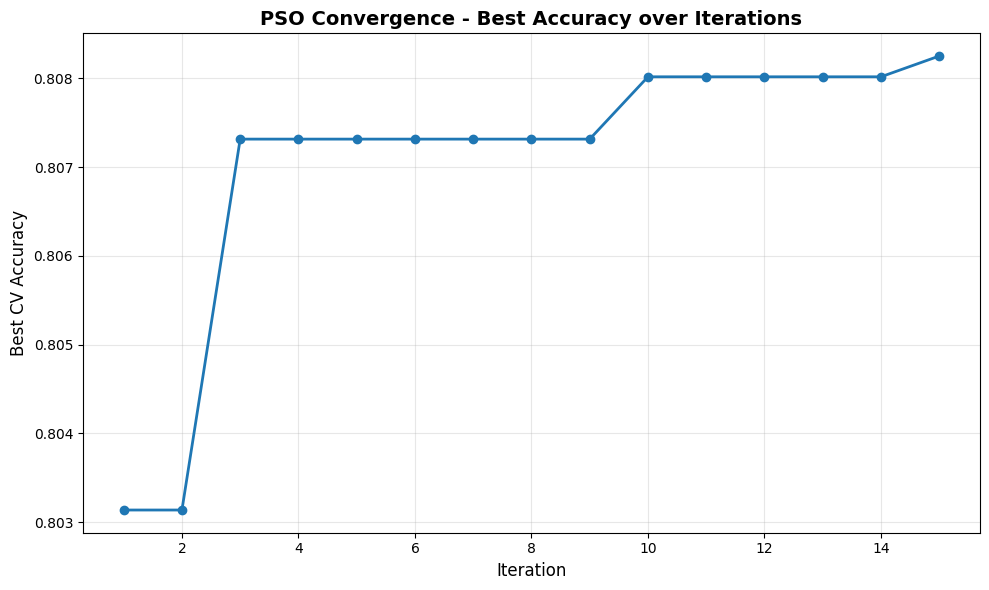

In [19]:
# Plot PSO convergence
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pso.history)+1), pso.history, marker='o', linewidth=2, markersize=6)
plt.title('PSO Convergence - Best Accuracy over Iterations', fontsize=14, fontweight='bold')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Best CV Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
# Predictions
y_pred_train = final_model.predict(X_train_final)
y_pred_test = final_model.predict(X_test_final)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nTraining Accuracy: {train_accuracy:.6f}")
print(f"Test Accuracy: {test_accuracy:.6f}")

# CLASSIFICATION REPORT
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)

print("\n", classification_report(y_test, y_pred_test, 
                                  target_names=['No Default (0)', 'Default (1)']))

# Additional metrics
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

y_pred_proba = final_model.predict_proba(X_test_final)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)

print("\nAdditional Metrics:")
print(f"  ROC-AUC Score: {roc_auc:.6f}")
print(f"  F1 Score: {f1:.6f}")
print(f"  Precision: {precision:.6f}")
print(f"  Recall: {recall:.6f}")


Training Accuracy: 0.837915
Test Accuracy: 0.810500

CLASSIFICATION REPORT

                 precision    recall  f1-score   support

No Default (0)       0.85      0.91      0.88      4673
   Default (1)       0.60      0.45      0.51      1327

      accuracy                           0.81      6000
     macro avg       0.72      0.68      0.70      6000
  weighted avg       0.80      0.81      0.80      6000


Additional Metrics:
  ROC-AUC Score: 0.765716
  F1 Score: 0.510125
  Precision: 0.595573
  Recall: 0.446119



CONFUSION MATRIX

Confusion Matrix:
[[4271  402]
 [ 735  592]]


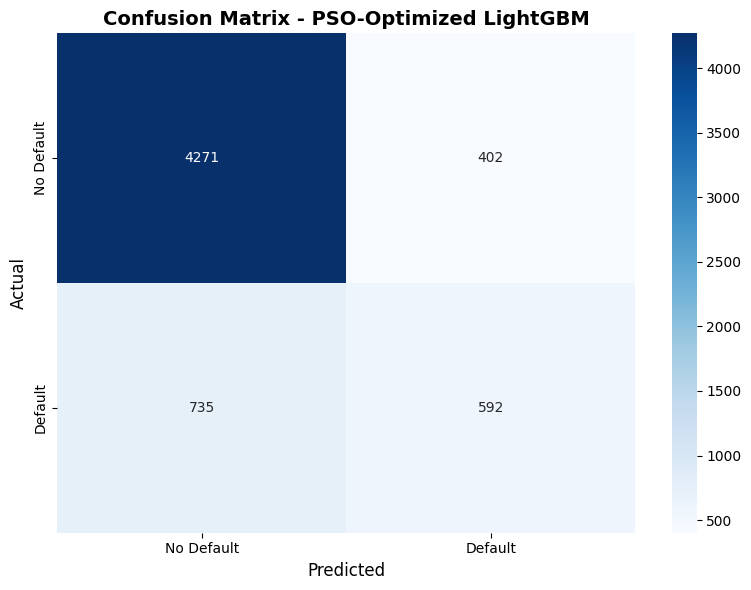

In [21]:
# CONFUSION MATRIX
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)

cm = confusion_matrix(y_test, y_pred_test)
print(f"\nConfusion Matrix:\n{cm}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix - PSO-Optimized LightGBM', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()